In [1]:
import heeps
from astropy.io import fits
import os.path
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import proper
from heeps.optics import apodizer, fp_mask, lyot_stop, detector
from heeps.wavefront import propagate_one, get_wf

### Find RAVC mean values

(10526, 10526)

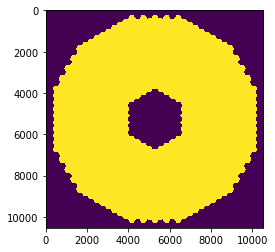

In [2]:
folder = os.path.expandvars('$HOME/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL')
pup = fits.getdata(os.path.join(folder, 'mask_M1.fits'))
plt.imshow(pup)
pup.shape

In [3]:
npupil = pup.shape[0]
dn = 2/npupil
pup_range = np.arange(-1, 1, dn) + dn/2
xi,yi = np.meshgrid(pup_range, pup_range)
ri = np.abs(xi + 1j*yi)
tota_area = npupil**2
outer_area = np.sum((1-pup)[ri>0.5])
inner_area = np.sum((1-pup)[ri<0.5])
r_ext = np.sqrt((tota_area - outer_area)/np.pi)
r_int = np.sqrt(inner_area/np.pi)
pupil_img_size = 39.9988
diam_M1 = 38.542
diam_allglass = 36.905
diam_ext = 2*r_ext/npupil*pupil_img_size # 37.812
diam_int = 2*r_int/npupil*pupil_img_size # 10.196
print('diam_ext=%s, diam_int=%s'%(diam_ext, diam_int))
r_obstr = diam_int/diam_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4  # 0.79
ravc_r = r_obstr/np.sqrt(1 - ravc_t)                           # 0.59
# calculate radius wrt 'allglass' diameter
ravc_r *= diam_ext/diam_allglass
print('ravc_t=%s, ravc_r=%s'%(ravc_t, ravc_r))

diam_ext=37.811776354402106, diam_int=10.195674065190712
ravc_t=0.7902924530036044, ravc_r=0.6032866343396053


### Visualize ELT PSF

Update config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2682
   ravc_calc=True, ravc_t=0.7779, ravc_r=0.6029
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   ndet=365, hfov=1.0 arcsec (48.94 lam/D)

Load pupil from 'ELT_pupil_1385.fits'
   diam=38.54 m, resize to 285 pix, zero-pad to 1024 pix



0.9965073014358002

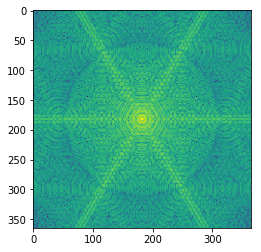

In [4]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis'
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
elt = detector(deepcopy(wf), **conf)
plt.imshow(np.log10(elt))
np.sum(elt)

### Run simulations with average diameters

In [30]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis',
    diam_ext = diam_ext, # 37.812
    diam_int = diam_int, # 10.196
    ravc_calc = False
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

rs = np.linspace(0.28, 0.63, 20)
ts = np.linspace(0.36, 0.83, 24)
#rs = np.linspace(0.28, 0.63, 2)
#ts = np.linspace(0.42, 0.83, 4)
contrast = np.zeros((len(rs),len(ts)))
thruput = np.zeros((len(rs),len(ts)))
best_C = []
best_T = []
best_CT2 = []
t_C = []
t_T = []
t_CT2 = []
for i,r in enumerate(rs):
    if not i%6:
        print('i=%s'%i)
    for j,t in enumerate(ts):
        conf['ravc_r'] = r
        conf['ravc_t'] = t
        offaxis = propagate_one(deepcopy(wf), onaxis=False, savefits=False, verbose=False, **conf)
        thruput[i,j] = np.sum(offaxis) 
        onaxis = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
        contrast[i,j] = np.sum(onaxis) 
        if j==0:
            best_C.append(contrast[i,j])
            best_T.append(thruput[i,j])
            best_CT2.append(contrast[i,j]/thruput[i,j]**2)
            t_C.append(t)
            t_T.append(t)
            t_CT2.append(t)
        else:
            if contrast[i,j] < best_C[-1]:
                best_C[-1] = contrast[i,j]
                t_C[-1] = t
            if thruput[i,j] > best_T[-1]:
                best_T[-1] = thruput[i,j]
                t_T[-1] = t
            CT2 = contrast[i,j]/thruput[i,j]**2
            if CT2 < best_CT2[-1]:
                best_CT2[-1] = CT2
                t_CT2[-1] = t

Update config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2631
   ravc_calc=False, ravc_t=0.7600, ravc_r=0.6200
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   ndet=365, hfov=1.0 arcsec (48.02 lam/D)

Load pupil from 'ELT_pupil_1385.fits'
   diam=37.81 m, resize to 285 pix, zero-pad to 1024 pix

i=0
i=6
i=12
i=18


### Contrast map

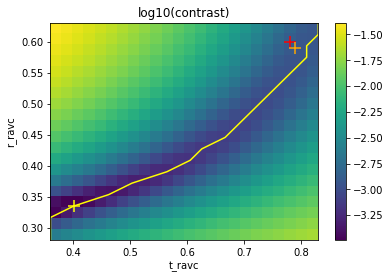

In [64]:
import matplotlib.pyplot as plt
plt.imshow(np.log10(contrast), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.plot(t_C, rs, c='yellow')
plt.scatter(0.78, 0.60, s=150, c='red', marker='+')
plt.scatter(0.79, 0.59, s=150, c='orange', marker='+')
ind_min = np.unravel_index(np.argmin(contrast, axis=None), contrast.shape)
plt.scatter(ts[ind_min[1]], rs[ind_min[0]], s=150, c='yellow', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('log10(contrast)');
plt.savefig('map_contrast.png')

### Throughput map

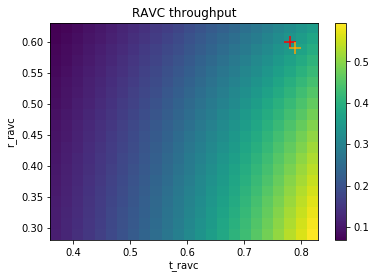

In [65]:
import matplotlib.pyplot as plt
plt.imshow((thruput), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.scatter(0.78, 0.60, s=150, c='red', marker='+')
plt.scatter(0.79, 0.59, s=150, c='orange', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('RAVC throughput');
plt.savefig('map_thruput.png')

### Contrast / throughput^2


optimum: t=0.7483, r=0.5011


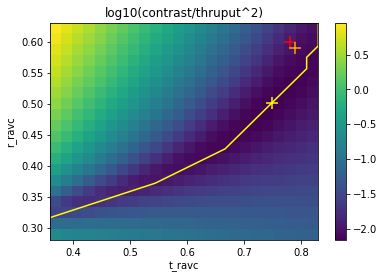

In [97]:
import matplotlib.pyplot as plt
CT2 = contrast/thruput**2
plt.imshow(np.log10(CT2), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.plot(t_CT2[2:], rs[2:], c='yellow')
plt.scatter(0.78, 0.60, s=150, c='red', marker='+')
plt.scatter(0.79, 0.59, s=150, c='orange', marker='+')
ind_min = np.unravel_index(np.argmin(CT2, axis=None), CT2.shape)
plt.scatter(ts[ind_min[1]], rs[ind_min[0]], s=150, c='yellow', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('log10(contrast/thruput^2)');
plt.savefig('map_CT2.png')
print('optimum: t=%3.4f, r=%3.4f'%(ts[ind_min[1]], rs[ind_min[0]]))

In [99]:
len(rs)

20

### All glass

Create pupil: spi_width=0.5 m, seg_width=1.45 m, seg_gap=0.004 m, seg_rms=0
   diam=36.91 m, resize to 285 pix, zero-pad to 1024 pix

0.6212896682141414 0.760841973016398 True


4.9594089337268235e-05

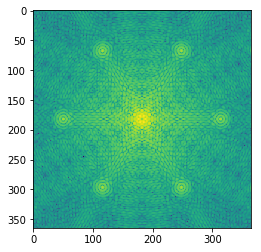

In [38]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis',
    file_pupil = '',
    diam_ext = 36.905,
    diam_int = 11.213,
    ravc_calc = True
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
wf = heeps.pupil.pupil(savefits=False, verbose=True, **conf)
psf = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
plt.imshow(np.log10(psf))
print(conf['ravc_r'],conf['ravc_t'],conf['ravc_calc'])
np.sum(psf)

### M1 pupil, nominal values

Load pupil from 'ELT_pupil_1385.fits'
   diam=38.54 m, resize to 285 pix, zero-pad to 1024 pix

0.602917594586273 0.7778724326117076 True


0.0029019602459344294

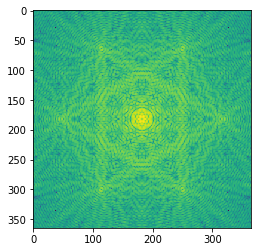

In [39]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis',
    diam_ext = 38.542,
    diam_int = 10.952,
    ravc_calc = True
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
wf = heeps.pupil.pupil(savefits=False, verbose=True, **conf)
psf = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
plt.imshow(np.log10(psf))
print(conf['ravc_r'],conf['ravc_t'],conf['ravc_calc'])
np.sum(psf)

### M1 pupil, average diameters

Load pupil from 'ELT_pupil_1385.fits'
   diam=38.54 m, resize to 285 pix, zero-pad to 1024 pix

0.59 0.79 False


0.0026392009211167384

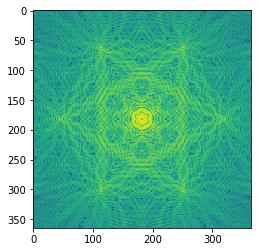

In [40]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis',
    diam_ext = 38.542,
    diam_int = 10.952,
    ravc_calc = False,
    ravc_r = 0.59,
    ravc_t = 0.79
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
wf = heeps.pupil.pupil(savefits=False, verbose=True, **conf)
psf = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
plt.imshow(np.log10(psf))
print(conf['ravc_r'],conf['ravc_t'],conf['ravc_calc'])
np.sum(psf)

### M1 pupil, minimal contrast

Load pupil from 'ELT_pupil_1385.fits'
   diam=38.54 m, resize to 285 pix, zero-pad to 1024 pix

0.35 0.47 False


0.0008861848144023604

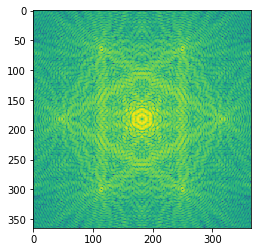

In [10]:
conf = dict(
    dir_current = '$HOME/Desktop/heeps_analysis',
    diam_ext = 38.542,
    diam_int = 10.952,
    ravc_calc = False,
    ravc_r = 0.35,
    ravc_t = 0.47
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
wf = heeps.pupil.pupil(savefits=False, verbose=True, **conf)
psf = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
plt.imshow(np.log10(psf))
print(conf['ravc_r'],conf['ravc_t'],conf['ravc_calc'])
np.sum(psf)